The investigation is predicated off of two papers that were both published last year. The first is "Figure Rotation of IllustrisTNG Halos" (Ash & Valluri 2023), which established a catalog of galaxies (simulated in the magnetohydrodynamical simulation suite IllustrisTNG)  with dark matter (DM) halos that experienced a tumbling motion termed "figure rotation" (FR), establishing that this FR axis was often aligned with the minor axis of the DM halo. The second is "Tilted Dark Halos are Common, Long-Lived, and can Warp Galactic Disks" (Jesse Han et al 2023), in which the tilt is quantified as the misalignment between the halo's minor axis and the disk's angular momentum axis and correlated with the warp of Milky Way analogs in TNG, given a 1 Gyr lag (seen below).

Given the correlation of the misalignment between the halo minor axis and the spin axis and Ash's finding that the FR axis is often aligned with the minor axis, it was thought that a misalignment between the FR axis and disk spin axis was inducing warp in the disks that Jesse Han studied. This project aims to investigate this possible relation between the figure rotation of dark matter halos and the warping of stellar disks in galaxies, IllustrisTNG's highest-resolution option, TNG50, in dark matter+baryonic simulation. The current phase of this project is researching primarily the aforementioned misalignment of the FR axis and the disk spin axis, with some looks at the tilt vs warp as well for a check of past work and methodology.

In [1]:
#Import everything necessary
import illustris_python as il
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.cm
import numpy as np
import h5py
from os.path import exists 
from scipy import stats
from numpy.linalg import inv
import pandas as pd
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm
from scipy.interpolate import CubicSpline
plt.style.use('mplstyle.txt')

import sys
sys.path.append('/home/tnguser/python/')

from matplotlib import rcParams
from matplotlib import cm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
rcParams['font.size'] = 18

sim = 'L35n2160TNG'
basePath = '/home/tnguser/sims.TNG/' + sim + '/output'

# Halos in Neil Ash's catalog w/ figure rotation
catalogue_path = '/home/tnguser/postprocessing/halocatalogues/' + sim + '.npy'
naive_halos = np.load(catalogue_path)
main_subhalos = np.load('/home/tnguser/postprocessing/halocatalogues/' + sim + '_mainSubhalos.npy') 

#Neil's data products
pattern_path =  '/home/tnguser/postprocessing/pattern_speeds/' + sim + '/00_06Rvir/'
principal_path =  '/home/tnguser/postprocessing/principal_axes/' + sim + '/00_06Rvir/'

#Angular momentum file path that doesn't actually get used as we show how it's calculated and then use it in calculating the angle
spin_path = '/home/tnguser/postprocessing/angular_momentum/' + sim + '/half_mass_rad/'

#Quantities calculated with methods that will be shown down the line
anglePath = '/home/tnguser/postprocessing/angles/' + sim + '/half_mass_rad/'
mag_path = '/home/tnguser/postprocessing/warp_magnitudes/'
mag_std_path = '/home/tnguser/postprocessing/uncertainties/warp_magnitudes/'
angle_std_path = '/home/tnguser/postprocessing/uncertainties/angles/'
warp_angle_path = '/home/tnguser/postprocessing/angles/' + sim + '/warp_angles/'

snap = 75
endSnap = 99


Bad key frameon in file mplstyle.txt, line 23 ('frameon: True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


I use two data product types calculated by Neil in his 2023 research on the figure rotation of dark matter halos: the pattern speed of the DM halo (how fast it rotates), and its principal axes (orientation of the dark matter halo in the simulation frame). Since this is based off of Neil's past work, the code in this Introduction section was written by a combination of him, me, and a previous student who began this project. Below are convenience functions for working in TNG.

In [2]:
def snapshot_redshift_corr(basePath,snap=75):
    """
    Calls and stores z = and redshift values
    """
    redshift_space = []
    for snapshot_number in range(snap,100):
        header=il.groupcat.loadHeader(basePath,snapshot_number) 
        redshift_space.append(header.get('Redshift')) 
    return np.arange(snap,100), np.array(redshift_space) 

def value(arr):
    """
    Convenience function, returns the item contained by an array,
    or an error if the array has more than one element
    """
    assert len(arr)<2
    return arr[0]

def make_unit(vec):
    """
    Convenience function, returns the unit-normalized vector
    """
    return 1/np.sqrt(np.sum(vec**2)) * vec

def getRotationAxis(snap, startStops, Raxis):
    """
    Returns the figure rotation axis at the snapshot snap
    """
    for idx, (first,second) in enumerate(startStops):
        if (snap >= first and snap < second):
            return Raxis[idx]
    return Raxis[-1]

def get_indices(lst, targets):
    return list(filter(lambda x: lst[x] in targets, range(len(lst))))

To make the measurements for my dataset, I used a warp decomposition of an azimuthal harmonic series by Neil Ash. We use a naive formalism similar to calculating the Fourier $A_2$ amplitude of a bar (for the fundamental mode). For an azimuthally-harmonic basis, we only need the $m=1$ mode:

$$  z(R) = \frac{2}{\sum_j M_j} \left| \sum_j M_j z_j \exp(i m\theta_j) \right| $$

We can also recover the warp phase-angle: 

$$ \varphi(R) = \frac{1}{m}\arctan2\left(\frac{\sum_jM_jz_j \sin(m\theta_j)}{\sum_jM_jz_j \cos(m\theta_j)}\right) $$

Where the summation is carried out over all particles in some azimuthal bin. The class is defined below. In the context of 406, a step of the method is decomposing the warp's z-height as seen edge-on with an interpolating CubicSpline.

In [3]:
class decomposeDisk:
    
    def __init__(self,coords,mass,bins,mmax=4):
        """
        Decompose the vertical structure of the disk into an Azimuthal-Harmonic basis set.
        Inputs:
                coords: Cartesian (x,y,z) positions of the disk particles, assumed to be 
                        centered and rotated such that the central angular momentum axis 
                        lies along z
                        
                mass:   Masses of each particle
                
                bins:   annular bins in which to perform the expansion
                
                mmax:   maximum m order of the expansion. Usually higher than 1 is not needed, 
                        and may be excessively noisy currently
                        
        Outputs: 
                None
        
        """
        # Convert to cylindrical
        self.R = np.sqrt(coords[:,0]**2+coords[:,1]**2)
        self.Theta = np.arctan2(coords[:,1],coords[:,0])
        self.Z = coords[:,2]
        self.mass = mass
        self.mmax = mmax
        
        # Set up loop through bins, run decomposition on each
        self.z_m_R = []
        self.bin_centers = []
        for i in range(len(bins)-1): 
            bin_indices = (self.R>bins[i])&(self.R<bins[i+1])
            self.z_m_R.append(self.decompose(bin_indices))
            self.bin_centers.append(np.sum(mass[bin_indices]*self.R[bin_indices])/np.sum(mass[bin_indices]))
        
        # Get the mag and phase angle of coefficients
        self.z_m_R = np.array(self.z_m_R)
        self.z_m_R_mag = np.real(np.sqrt(self.z_m_R*np.conj(self.z_m_R)))
        self.z_m_R_PA = 1/np.arange(mmax+1)*np.arctan2(np.imag(self.z_m_R),np.real(self.z_m_R))
        
        # mean particle position in each bin,
        self.bin_centers = np.array(self.bin_centers)
        self.z_m_Spl = CubicSpline(self.bin_centers,self.z_m_R)
        
    def decompose(self,indices):
        """
        Performs the decomposition into the basis set coefficient weights, 
        should only be used internally by __init__
        
        Inputs:
                indices: the indices into coords and mass to be considered in the decomposition
                
        Outputs:
                z_m_arr: the coefficient weights
        
        """
        z_m_arr = []
        for m in range(0,self.mmax+1,1):
            z_m = np.sum(self.mass[indices]*self.Z[indices]*np.exp(1j*m*self.Theta[indices])) /\
                    np.sum(self.mass[indices])
            if m != 0: z_m *= 2
            z_m_arr.append(z_m)
        return np.array(z_m_arr)        
        
    def reconstruct_disk(self,pos,m_inds=None):
        """
        Recover the model z-height above/below the nominal disk plane for selected m-modes
        Inputs: 
                pos:      array-like grid of points to return z-height along
                m_inds:   array-like or int, m-modes to use in model reconstruction
            
        Outputs:
                z_recov:  array of same shape as pos, the model z-value at pos
        """
        m_arr = np.arange(self.mmax+1)
        
        # Convert to cylindrical 
        R = np.sqrt(pos[:,0]**2+pos[:,1]**2)
        Theta = np.arctan2(pos[:,1],pos[:,0])
        
        # Get the interpolated coefficients
        z_m = self.z_m_Spl(R)
        
        # Recover phase angle and magnitude of coefficients
        z_phi = 1/m_arr * np.arctan2(np.imag(z_m),np.real(z_m))
        z_mag = np.real(np.sqrt(z_m*np.conj(z_m)))
        
        # Reconstruct z-profile, sum contribution from each m
        if m_inds is None:
            m_inds = m_arr
            
        z_recov_m = np.array([z_mag[:,m]*np.cos(m_arr[m]*(Theta-z_phi[:,m])) for m in m_arr])
        return np.nansum(z_recov_m[m_inds,:],axis=0)

To start measuring our dataset, we have to define it first. We used a supplementary TNG catalog that allows us to determine a number of disky halos through the circularity parameter. By using np.intersect1d, we obtained the halos in Neil's catalog that are disky, which is 63 halos. I have to delete the halos that do not have corresponding data products from Neil's calculations, leaving us with 51.

In [4]:
filename = "./stellar_circs.hdf5" # supplementary stellar circularity information
hf=h5py.File(filename,'r')
circ_subfindID = hf['Snapshot_99']['SubfindID']
circ07 = hf['Snapshot_99']['CircAbove07Frac']

disky_temp = circ_subfindID[np.where(np.array(circ07) > 0.5)] # definition of "disky" halos
diskyIDs = np.intersect1d(disky_temp,main_subhalos)
diskyIDs = np.delete(diskyIDs, [1, 10, 11, 14, 16, 23, 25, 26, 32, 34, 57, 58]) #Deleting halos without products
print("Number of disky halos at z=0:", len(diskyIDs))

Number of disky halos at z=0: 51


Now for some of the more fun stuff. In the cell below, we're loading in our galaxy and the attributes that we need to do our decomposition. Let's mention the organization here. The SubfindID is a unique integer that is attributed to each subhalo for each redshift value (or snapshot, in TNG terms). Above the SubfindID in the TNG hierarchy is the Group Number or GrNr, which identifies the parent halo that the subhalo emerged from as the result of a merger. However, a requirement of Neil's catalog was that halos remain merger-free, so the GrNr for our given lookback time of 4 Gyr can hold essentially the same identifying role as the SubfindID, but in fewer digits. After properly centering and rotating the galaxy from the simulation frame into the halo's body frame, we peform the warp decomposition out to three times the stellar half-mass-radius, a need for which we'll see later. After the decomposition, we can use the phase angle of to rotate the recovered warp to align with the halo, which we plot in a 2D histogram and plot the warp as a function of radius as well as its reflection, assuming a symmetrical warp. You might note that we call for these quantities at z = 0 (Snapshot 99) but load the halo as it was ~4 Gyr (Snapshot 75) ago --- we can do this by TNG's organization of halos and mergers through the merger tree, and specify we only want to load our quantities for a given snapshot from the Main Progenitor Branch.

In [5]:
final_diskyIDs = np.load('/home/tnguser/postprocessing/circularity_study/real_final_diskyIDs.npy')

In [6]:
snap = 91
subfindID = final_diskyIDs[23]
GrNr = (il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])

snapArr,zArr = snapshot_redshift_corr(basePath)
haloTree = il.lhalotree.loadTree(basePath,99,subfindID,
                                 fields=['SubhaloGrNr','SnapNum','Group_R_Crit200','SubhaloPos','SubhaloNumber','SubhaloHalfmassRadType'], 
                                 onlyMPB=True)

haloInd,mpb_snapArr = haloTree['SubhaloGrNr'], haloTree['SnapNum']
subfindID = haloTree['SubhaloNumber']
Rvirial   = haloTree['Group_R_Crit200']
subhaloPos = haloTree['SubhaloPos']
halfmassrad = haloTree['SubhaloHalfmassRadType']
h = 0.678
GrNr_i       = value(haloInd[snap == mpb_snapArr])
subfindID_i  = value(subfindID[snap == mpb_snapArr])
Rvirial_i    = value(Rvirial[snap == mpb_snapArr])
subhaloPos_i = value(subhaloPos[snap == mpb_snapArr])
a = 1/(1+value(zArr[snap==snapArr]))
halfmassrad_i = value(halfmassrad[snap == mpb_snapArr])[4]*a

starPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Coordinates')
starVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Velocities')
starMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Masses') 

    # following Neil's method, but only using stars (not gas or DM)
if (type(starPos) is not dict):
    particleCoords_bar  = starPos
    particleVels_bar    = starVel
    particleMass_bar    = starMass * 1e10
else:
        # no stars in the halo
    print("ERROR: no stars in halo.")
    particleCoords_bar  = np.array([[np.nan,np.nan,np.nan]])
    particleVels_bar    = np.array([[np.nan,np.nan,np.nan]])
    particleMass_bar    = np.array([np.nan])

    ########################################################################
    # check that the halo is not crossing the box boundary, correct if it is
    # condition is whether it is within 2 virial radii
passUpperBound = subhaloPos_i + 2*Rvirial_i >= 35000
passLowerBound = subhaloPos_i - 2*Rvirial_i <= 0

if any(passUpperBound):
        # shift the particles
    particleCoords_bar[:,passUpperBound] = particleCoords_bar[:,passUpperBound] - 35000/2
    subhaloPos_i[passUpperBound] = subhaloPos_i[passUpperBound] - 35000/2
        #reinforce boundary condition
    ind_bar = np.where(particleCoords_bar[:,passUpperBound]<0)[0]
    particleCoords_bar[ind_bar,passUpperBound] = particleCoords_bar[ind_bar,passUpperBound] + 35000

if any(passLowerBound):
    particleCoords_bar[:,passLowerBound] = particleCoords_bar[:,passLowerBound] + 35000/2 
    subhaloPos_i[passLowerBound] = subhaloPos_i[passLowerBound] + 35000/2

    ind_bar = np.where(particleCoords_bar[:,passLowerBound]>35000)[0]
    particleCoords_bar[ind_bar,passLowerBound] = particleCoords_bar[ind_bar,passLowerBound] - 35000
    ########################################################################

    # center coords on subhalo pos
particleCoords_bar = (particleCoords_bar - subhaloPos_i)*a
    # find relative velocities - shouldn't have done this, instead use the spin by TNG (includes DM)
paricleVels_bar = (particleVels_bar - np.mean(particleVels_bar,axis=0)) * np.sqrt(a) # km/s

# Rotate into plane of inner disk
r = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
in_half = r<=halfmassrad_i

L_parts = particleMass_bar.reshape(-1,1) * np.cross(particleCoords_bar,
                                                      paricleVels_bar)
L_spec_half = (np.sum(L_parts[in_half],axis=0) / np.sum(particleMass_bar[in_half]).reshape(-1,1)).reshape(3)

e3 = L_spec_half / np.sqrt(np.sum(L_spec_half**2))
e1 = np.cross(np.array([0,1,0]),e3)
e1 = e1 / np.sqrt(np.sum(e1**2))
e2 = np.cross(e3,e1)

Rmat = np.array([e1,e2,e3]).T

# Rotate
particleCoords_bar = Rmat.T.dot(particleCoords_bar.T).T
particleVels_bar = Rmat.T.dot(particleVels_bar.T).T

bins = np.logspace(0,np.log10(3*halfmassrad_i),10)
mmax = 4
# Decompose the disk 
warpModel = decomposeDisk(particleCoords_bar,
                      particleMass_bar,bins,mmax=mmax)
recover_wa = np.median(warpModel.z_m_R_PA[:,1])
Rz = np.array([[np.cos(recover_wa),-np.sin(recover_wa),0],
               [np.sin(recover_wa),np.cos(recover_wa),0],
               [0,0,1]])

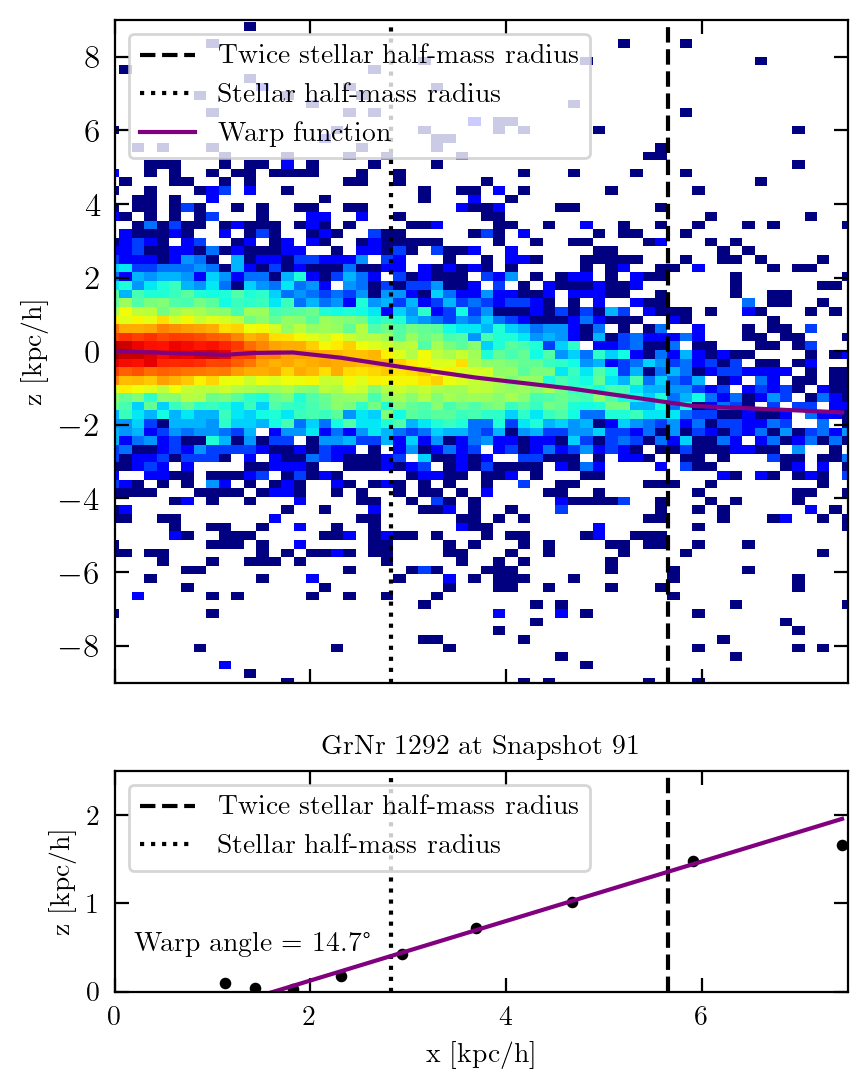

In [7]:
fig,axes = plt.subplots(2,1,figsize=(4.733,4.733+4.733/3),height_ratios=(3,1))
plt.title(f'GrNr {GrNr} at Snapshot {snap}',fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
pos_warp_rot = Rz.dot(particleCoords_bar.T).T

axes[0].hist2d(pos_warp_rot[:,0], pos_warp_rot[:,2], bins=(640,640), norm=mpl.colors.LogNorm(),cmap=plt.cm.jet)
axes[0].set_ylabel("z [kpc/h]",fontsize=10)
axes[0].set_xlim(-9,9)
axes[0].set_ylim(-9,9)

axes[0].axvline(2*halfmassrad_i,linestyle='--',c='black',label='Twice stellar half-mass radius')
axes[0].axvline(halfmassrad_i,linestyle=':',c='black',label='Stellar half-mass radius')
axes[0].axvline(-halfmassrad_i,linestyle=':',c='black')
axes[0].axvline(-2*halfmassrad_i,linestyle='--',c='black')

bin_centers_reflected = np.concatenate((np.flipud(-warpModel.bin_centers),warpModel.bin_centers))
z_R_reflected = np.concatenate((np.flipud(-warpModel.z_m_R_mag[:,1]),warpModel.z_m_R_mag[:,1]))
axes[0].plot(np.flipud(bin_centers_reflected),z_R_reflected,color='purple',label='Warp function')
axes[0].legend(fontsize=10)

def func(x,m,b):
    return m*x + b
from scipy.optimize import curve_fit

halfmassradID = np.where(warpModel.bin_centers > halfmassrad_i)[0][0]
twicehalfmassradID = np.where(warpModel.bin_centers > 2*halfmassrad_i)[0][0]

axes[1].axvline(2*halfmassrad_i,linestyle='--',c='black',label='Twice stellar half-mass radius')
axes[1].axvline(halfmassrad_i,linestyle=':',c='black',label='Stellar half-mass radius')
axes[1].scatter(warpModel.bin_centers,warpModel.z_m_R_mag[:,1], c='black',s=10)
axes[1].set_xlabel("x [kpc/h]",fontsize=10)
axes[1].set_ylabel("z [kpc/h]",fontsize=10)
popt, pcov = curve_fit(func, warpModel.bin_centers[halfmassradID:twicehalfmassradID], 
                       warpModel.z_m_R_mag[:,1][halfmassradID:twicehalfmassradID])
axes[1].plot(warpModel.bin_centers, func(warpModel.bin_centers, *popt), c='purple')
warp_z_angle = (np.degrees(np.arctan([func(warpModel.bin_centers, *popt)[-1]/warpModel.bin_centers[-1]])))
arr_str = str(np.round(warp_z_angle, 1))
result = arr_str.lstrip('[').rstrip(']')
axes[1].xlim(0,7.5)
axes[1].ylim(0,2.5)
axes[1].text(0.2,.45,f'Warp angle = {result}°',fontsize=10)
axes[1].legend(fontsize=10)

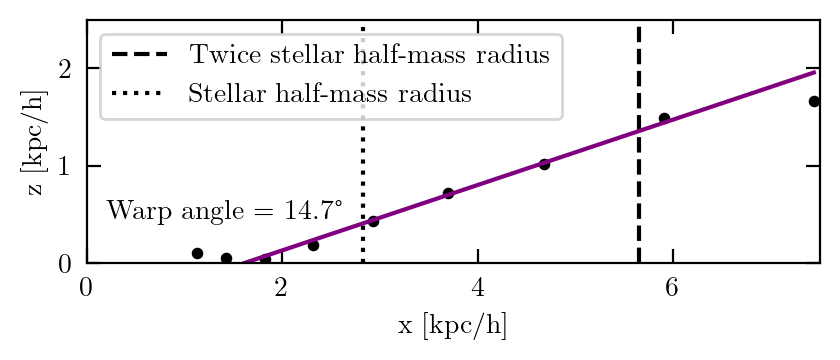

In [14]:
def func(x,m,b):
    return m*x + b
from scipy.optimize import curve_fit

halfmassradID = np.where(warpModel.bin_centers > halfmassrad_i)[0][0]
twicehalfmassradID = np.where(warpModel.bin_centers > 2*halfmassrad_i)[0][0]

plt.figure(figsize=(4.733, 4.733/3))
plt.axvline(2*halfmassrad_i,linestyle='--',c='black',label='Twice stellar half-mass radius')
plt.axvline(halfmassrad_i,linestyle=':',c='black',label='Stellar half-mass radius')
plt.scatter(warpModel.bin_centers,warpModel.z_m_R_mag[:,1], c='black',s=10)
plt.xlabel("x [kpc/h]",fontsize=10)
plt.ylabel("z [kpc/h]",fontsize=10)
popt, pcov = curve_fit(func, warpModel.bin_centers[halfmassradID:twicehalfmassradID], 
                       warpModel.z_m_R_mag[:,1][halfmassradID:twicehalfmassradID])
plt.plot(warpModel.bin_centers, func(warpModel.bin_centers, *popt), c='purple')
warp_z_angle = (np.degrees(np.arctan([func(warpModel.bin_centers, *popt)[-1]/warpModel.bin_centers[-1]])))
arr_str = str(np.round(warp_z_angle, 1))
result = arr_str.lstrip('[').rstrip(']')
plt.xlim(0,7.5)
plt.ylim(0,2.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.text(0.2,.45,f'Warp angle = {result}°',fontsize=10)
plt.legend(fontsize=10)

In [7]:
warps_91 = warpModel.z_m_R_mag.T

In [8]:
warps = []
for snap in tqdm(range(75,100)):
    GrNr_i       = value(haloInd[snap == mpb_snapArr])
    subfindID_i  = value(subfindID[snap == mpb_snapArr])
    Rvirial_i    = value(Rvirial[snap == mpb_snapArr])
    subhaloPos_i = value(subhaloPos[snap == mpb_snapArr])
    a = 1/(1+value(zArr[snap==snapArr]))
    halfmassrad_i = value(halfmassrad[snap == mpb_snapArr])[4]*a

    starPos = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Coordinates')
    starVel = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Velocities')
    starMass = il.snapshot.loadSubhalo(basePath,snap,subfindID_i,4,fields='Masses') 

        # following Neil's method, but only using stars (not gas or DM)
    if (type(starPos) is not dict):
        particleCoords_bar  = starPos
        particleVels_bar    = starVel
        particleMass_bar    = starMass * 1e10
    else:
            # no stars in the halo
        print("ERROR: no stars in halo.")
        particleCoords_bar  = np.array([[np.nan,np.nan,np.nan]])
        particleVels_bar    = np.array([[np.nan,np.nan,np.nan]])
        particleMass_bar    = np.array([np.nan])

        ########################################################################
        # check that the halo is not crossing the box boundary, correct if it is
        # condition is whether it is within 2 virial radii
    passUpperBound = subhaloPos_i + 2*Rvirial_i >= 35000
    passLowerBound = subhaloPos_i - 2*Rvirial_i <= 0

    if any(passUpperBound):
            # shift the particles
        particleCoords_bar[:,passUpperBound] = particleCoords_bar[:,passUpperBound] - 35000/2
        subhaloPos_i[passUpperBound] = subhaloPos_i[passUpperBound] - 35000/2
            #reinforce boundary condition
        ind_bar = np.where(particleCoords_bar[:,passUpperBound]<0)[0]
        particleCoords_bar[ind_bar,passUpperBound] = particleCoords_bar[ind_bar,passUpperBound] + 35000

    if any(passLowerBound):
        particleCoords_bar[:,passLowerBound] = particleCoords_bar[:,passLowerBound] + 35000/2 
        subhaloPos_i[passLowerBound] = subhaloPos_i[passLowerBound] + 35000/2

        ind_bar = np.where(particleCoords_bar[:,passLowerBound]>35000)[0]
        particleCoords_bar[ind_bar,passLowerBound] = particleCoords_bar[ind_bar,passLowerBound] - 35000
        ########################################################################

        # center coords on subhalo pos
    particleCoords_bar = (particleCoords_bar - subhaloPos_i)*a
        # find relative velocities - shouldn't have done this, instead use the spin by TNG (includes DM)
    paricleVels_bar = (particleVels_bar - np.mean(particleVels_bar,axis=0)) * np.sqrt(a) # km/s

    # Rotate into plane of inner disk
    r = np.sqrt(np.sum(particleCoords_bar**2,axis=1))
    in_half = r<=halfmassrad_i

    L_parts = particleMass_bar.reshape(-1,1) * np.cross(particleCoords_bar,
                                                          paricleVels_bar)
    L_spec_half = (np.sum(L_parts[in_half],axis=0) / np.sum(particleMass_bar[in_half]).reshape(-1,1)).reshape(3)

    e3 = L_spec_half / np.sqrt(np.sum(L_spec_half**2))
    e1 = np.cross(np.array([0,1,0]),e3)
    e1 = e1 / np.sqrt(np.sum(e1**2))
    e2 = np.cross(e3,e1)

    Rmat = np.array([e1,e2,e3]).T

    # Rotate
    particleCoords_bar = Rmat.T.dot(particleCoords_bar.T).T
    particleVels_bar = Rmat.T.dot(particleVels_bar.T).T

    bins = np.logspace(0,np.log10(3*halfmassrad_i),10)
    mmax = 4
    # Decompose the disk 
    warpModel = decomposeDisk(particleCoords_bar,
                          particleMass_bar,bins,mmax=mmax)
    warps.append(np.max(warpModel.z_m_R_mag,0))

100%|██████████| 25/25 [00:14<00:00,  1.74it/s]


In [11]:
from matplotlib import colors

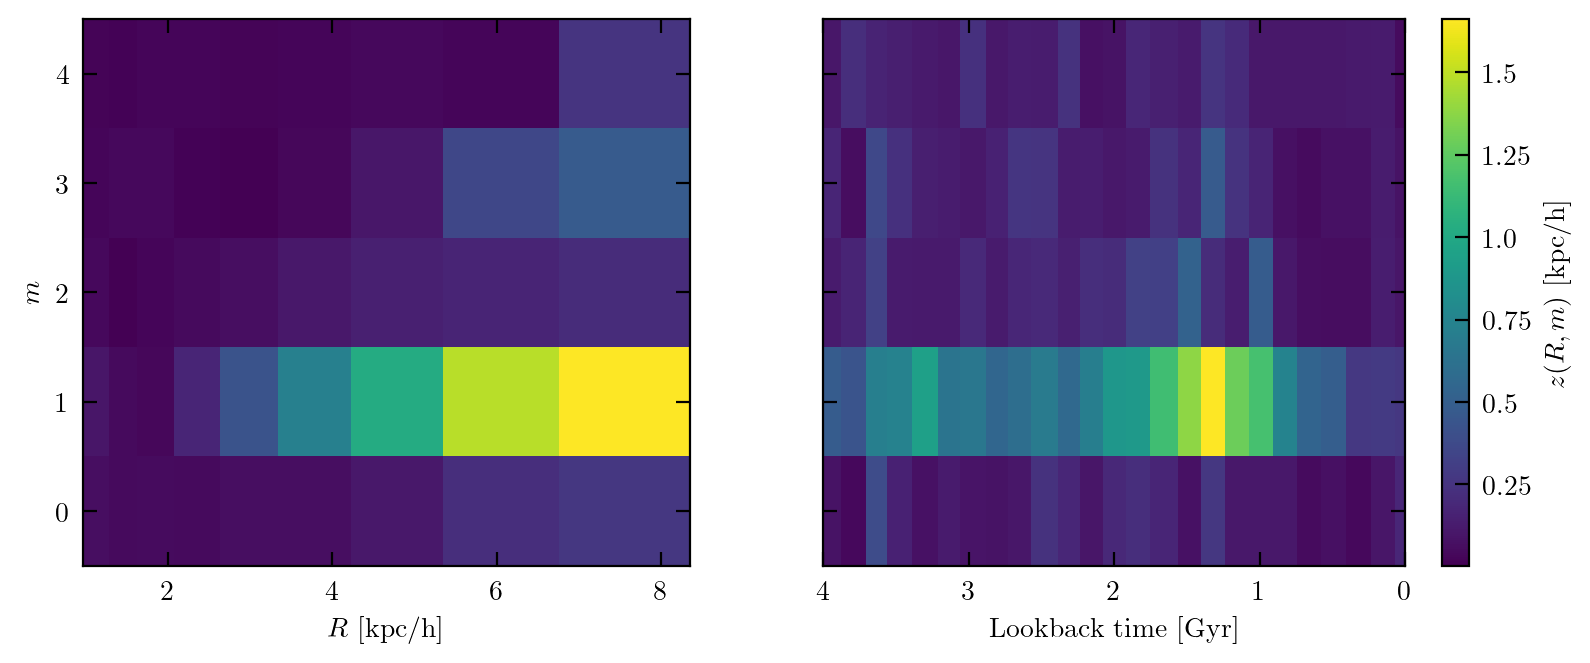

In [14]:
snapshot_times = [3.966,3.794,3.621,3.504,3.269,3.149,2.969,2.787,2.665,2.480,2.294,2.169,1.979,1.852,1.660,1.466,1.336,1.140,1.008,0.810,0.676,0.475,0.340,0.136,0]
fig,axes = plt.subplots(1,2,figsize=(2*4.733,3.55),sharey=True,width_ratios=[1,1.2])
norm = colors.Normalize(vmin=np.min(warps_91), vmax=np.max(warps_91))

axes[0].pcolormesh(warpModel.bin_centers, np.arange(5), warps_91, shading='nearest', norm=norm)
axes[0].set_xlabel(r"$R$ [kpc/h]",fontsize=10)
axes[0].set_ylabel(r'$m$',fontsize=10)
axes[0].tick_params(axis='x', labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)

axes[1].tick_params(axis='x', labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)
axes[1].set_xlabel(r"Lookback time [Gyr]",fontsize=10)
axes[1].set_xlim(4,0)
im = axes[1].pcolormesh(snapshot_times, np.arange(5), np.array(warps).T, shading='nearest', norm=norm)
cbar = plt.colorbar(im)
cbar.set_ticklabels(np.arange(0,1.75,0.25),fontsize = 10)
cbar.set_label(r'$z(R,m)$ [kpc/h]',fontsize = 10)

We can see the warp of this disk is recovered well, and that we can take an effective measurement at twice the half-mass-radius, which goes right to the border of the disk, but not too far. We want the warp of the whole disk, so measuring within twice the half-mass-radius isn't effective, as well as far beyond in the edge of the disk as warp measurements become exaggerated the further out we are from the disk due to a lack of stars. The three cells below are relatively much simpler to everything we just covered. The first calculates the angular momentum of the disk within the half-mass-radius as to not factor the warp in the outer disk, and that spin axis is used to calculate the misalignment (FR axis vs disk spin axis) and tilt angle (halo minor axis vs disk spin axis). We also curtail the measurement to be below 90 as to quantify the absolute angular displacement.

### Methodology

Now, I do have the raw warp amplitude as was measured in Jesse Han's research, but I particularly want a metric that express the degree of warp proportional to a galaxy's size. I at first took a "relative warp magnitude" that divided a raw warp magnitude by the half-mass-radius, but that was a precursor to the warp angle: the angle of a linear chi^2 regression of the z-height as a function of radius specifically applied in the region from the half-mass radius to twice the half-mass-radius. As we noted before, within the half-mass-radius the warp is too low for proper measurement and past twice the half-mass radius is too high. To generate an uncertainty estimate, I plotted out confidence intervals using curve_fit's uncertainties from its covariance matrix. I then took the angle of those lines, noted each of their differences from the measured angle, and took their mean.

I was responsible for expanding this project out to concern warp and misalignment evolution, therefore I had to check which halos out of our 51 halos were disky for the entire span of 4 Gyr. Below is the cell I used to do this, by loading the disky catalog at Snapshot 75 and checking if the SubfindID for one of my halos for Snapshot 75 loaded from the progenitor branch was contained within that catalog. I also did another check outside of this notebook to check diskiness at every single snapshot, which just confirmed what we had suspected --- that 4 Gyr wasn't enough time for a galaxy to become a disk, then stop being a disk, and then become a disk again. We can then load the group numbers for those halos, and see that our catalog drops from 51 to 23.

In [10]:
disky_GrNr_from75 = []

for subfindID in diskyIDs_from75:
    GrNr = il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr']
    disky_GrNr_from75.append(il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr'])
print("Number of halos disky for snapshots 75-99:", len(disky_GrNr_from75))

Number of halos disky for snapshots 75-99: 23


There's actually one more cut we need to make, because as of 12/5/24, Neil let me know that he updated his catalog by applying a cut to halos with null detections of figure rotation --- the criteria essentially being those with pattern speeds too fast to be realistically generated. This doesn't mean we need to necessarily throw out these other halos however, we can use them as a sort of "control group" to establish that figure rotation does indeed play more of a part in warp that other null-FR DM halos do.

In [16]:
real_disky_GrNr = [772, 884, 920, 931, 974, 982, 1026, 1346, 1628, 1771, 2340, 2410] #Actual FR results
real_indices = get_indices(disky_GrNr_from75, real_disky_GrNr)
ctrl_indices = np.delete(np.arange(23), real_indices)

real_diskyIDs = []
for i in real_indices:
    real_diskyIDs.append(diskyIDs_from75[i])
    
ctrl_disky_GrNr = []
for i in ctrl_indices:
    ctrl_disky_GrNr.append(disky_GrNr_from75[i])

ctrl_diskyIDs = []
for i in ctrl_indices:
    ctrl_diskyIDs.append(diskyIDs_from75[i])

Also of course, we want some level of uncertainty analysis on more quantities than just the warp angle. For simulated quantities, we do this with bootstrapping. The cell below has been run in some variation for each quantity calculated.

  2%|▏         | 2/100 [00:00<00:07, 13.91it/s]

Using  87678  of  97421


100%|██████████| 100/100 [00:07<00:00, 13.91it/s]


Text(0.5, 0, '$Z(R_{cyl},m=1)$ [kpc/$h$]')

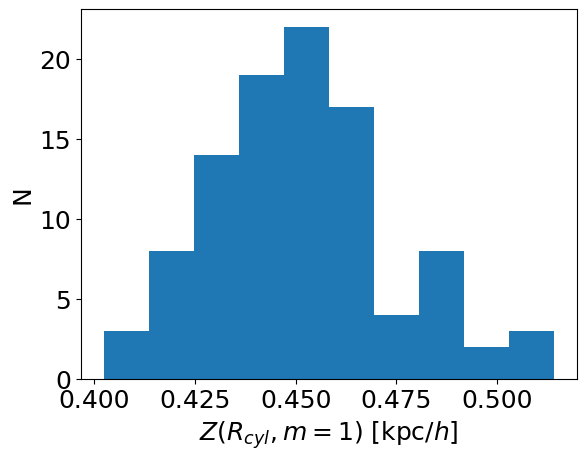

In [17]:
p = .9
N = 100
# BOOTSTRAPPING HERE
logBins = np.logspace(0,np.log10(3*halfmassrad_i),10)
mmax = 3
all_mags = []
for i in tqdm(np.arange(N)):
    # Choosing p percent of samples with repetition
    num_data = len(particleCoords_bar)
    num_samples = int(p * num_data)
    if i == 0:
        print("Using ", num_samples, " of ", num_data) # Want these to be ~equal
    random_indices = (np.random.randint(0,num_data,size=num_samples))
    warpModel = decomposeDisk(particleCoords_bar[random_indices],particleMass_bar[random_indices],logBins,mmax=mmax)

    all_mags.append(warpModel.z_m_R_mag[:,1][np.where(warpModel.bin_centers < 2*halfmassrad_i)[0][-1]])

mags_mean = (np.mean(all_mags))
mags_std = (np.std(all_mags))

plt.hist(all_mags)
plt.ylabel('N')
plt.xlabel(r'$Z(R_{cyl},m=1)$ [kpc/$h$]')

We can see I recover a fairly Gaussian distribution around our measurement. It could potentially be improved with more iterations or introducing a convergence criterion, but even 100 iterations for 23 halos through 25 snapshots takes a while. Now that we know how each point of data is produced, we can move onto analysis.

### Analysis

In [18]:
disky_angles = [] #misalignment angle between halo figure rotation axis and stellar spin axis
z_angles = [] #tilt angle, as the minor axis is often aligned with the z-axis in a Cartesian frame of a DM halo
warp_magnitudes = []
warp_z_angles = []
separation_angles = []

disky_angles_stds = []
z_angles_stds = []
warp_mags_stds = []
warp_z_angles_stds = []

rel_warp_magnitudes = []
rel_warp_mags_stds = []

for subfindID in real_diskyIDs:
    GrNr = il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr']
    angle_file = anglePath +'GrNr_%d_snap_%d_99_RaxisLaxis_L_angle.npy'%(GrNr,snap)
    z_file = anglePath + 'GrNr_%d_snap_%d_99_RaxisLaxis_z_angle.npy'%(GrNr,snap)
    magnitude_file = mag_path + 'GrNr_%d_snap_%d_99_warp_magnitudes.npy'%(GrNr,snap)
    warp_z_angles_file = warp_angle_path + 'GrNr_%d_snap_%d_99_warp_z_angles.npy'%(GrNr,snap)
    separation_angle_file = anglePath + 'GrNr_%d_snap_%d_99_minorAngle.npy'%(GrNr,snap)

    disky_angles_std_file = angle_std_path + 'GrNr_%d_snap_%d_99_RaxisLaxis_L_angle_std.npy.npy'%(GrNr,snap)
    z_angles_std_file = angle_std_path + 'GrNr_%d_snap_%d_99_RaxisLaxis_z_angle_std.npy.npy'%(GrNr,snap)
    warp_mags_std_file = mag_std_path + 'GrNr_%d_snap_%d_99_warp_magnitude_std.npy'%(GrNr,snap)
    warp_z_angle_std_file = angle_std_path + 'GrNr_%d_snap_%d_99_warp_z_angle_std.npy'%(GrNr,snap)

    rel_magnitude_file = mag_path + 'GrNr_%d_snap_%d_99_rel_warp_magnitudes.npy'%(GrNr,snap)
    rel_warp_mags_std_file = mag_std_path + 'GrNr_%d_snap_%d_99_rel_warp_magnitude_std.npy'%(GrNr,snap)    

    disky_angles.append(np.load(angle_file,allow_pickle=True))
    z_angles.append(np.load(z_file,allow_pickle=True))
    warp_magnitudes.append(np.load(magnitude_file,allow_pickle=True))  
    warp_z_angles.append(np.load(warp_z_angles_file,allow_pickle=True))  
    separation_angles.append(np.load(separation_angle_file,allow_pickle=True))  

    disky_angles_stds.append(np.load(disky_angles_std_file,allow_pickle=True))  
    z_angles_stds.append(np.load(z_angles_std_file,allow_pickle=True))  
    warp_mags_stds.append(np.load(warp_mags_std_file,allow_pickle=True))  
    warp_z_angles_stds.append(np.load(warp_z_angle_std_file,allow_pickle=True))  
    
    rel_warp_magnitudes.append(np.load(rel_magnitude_file,allow_pickle=True))
    rel_warp_mags_stds.append(np.load(rel_warp_mags_std_file,allow_pickle=True))  

In [19]:
np.shape(disky_angles)

(12, 25)

It's convenient for us to turn these lists of arrays into ndarrays, especially when taking measurements later that have to slice the columns of the datasets. Some blocks of code still have a redundant np.array argument however before I realized how to make life easier.

In [20]:
disky_angles = np.array(disky_angles)
z_angles = np.array(z_angles)
warp_magnitudes = np.array(warp_magnitudes)
warp_z_angles = np.array(warp_z_angles)
separation_angles = np.array(separation_angles)

warp_mags_stds = np.array(warp_mags_stds)
disky_angles_stds = np.array(disky_angles_stds)
z_angles_stds = np.array(z_angles_stds)
warp_z_angles_stds = np.array(np.abs(warp_z_angles_stds))

rel_warp_magnitudes = np.array(rel_warp_magnitudes)
rel_warp_mags_stds = np.array(rel_warp_mags_stds)

Let's load in the "control group" as well, not all of which are used but will be still useful for me to examine later.

In [21]:
ctrl_disky_angles = [] #misalignment angle between halo figure rotation axis and stellar spin axis
ctrl_z_angles = [] #tilt angle, as the minor axis is often aligned with the z-axis in a Cartesian frame of a DM halo
ctrl_warp_magnitudes = []
ctrl_warp_z_angles = []
ctrl_separation_angles = []

ctrl_disky_angles_stds = []
ctrl_z_angles_stds = []
ctrl_warp_mags_stds = []
ctrl_warp_z_angles_stds = []

ctrl_rel_warp_magnitudes = []
ctrl_rel_warp_mags_stds = []

for subfindID in ctrl_diskyIDs:
    GrNr = il.groupcat.loadSingle(basePath, 99, subhaloID=subfindID)['SubhaloGrNr']
    angle_file = anglePath +'GrNr_%d_snap_%d_99_RaxisLaxis_L_angle.npy'%(GrNr,snap)
    z_file = anglePath + 'GrNr_%d_snap_%d_99_RaxisLaxis_z_angle.npy'%(GrNr,snap)
    magnitude_file = mag_path + 'GrNr_%d_snap_%d_99_warp_magnitudes.npy'%(GrNr,snap)
    warp_z_angles_file = warp_angle_path + 'GrNr_%d_snap_%d_99_warp_z_angles.npy'%(GrNr,snap)
    separation_angle_file = anglePath + 'GrNr_%d_snap_%d_99_minorAngle.npy'%(GrNr,snap)

    disky_angles_std_file = angle_std_path + 'GrNr_%d_snap_%d_99_RaxisLaxis_L_angle_std.npy.npy'%(GrNr,snap)
    z_angles_std_file = angle_std_path + 'GrNr_%d_snap_%d_99_RaxisLaxis_z_angle_std.npy.npy'%(GrNr,snap)
    warp_mags_std_file = mag_std_path + 'GrNr_%d_snap_%d_99_warp_magnitude_std.npy'%(GrNr,snap)
    warp_z_angle_std_file = angle_std_path + 'GrNr_%d_snap_%d_99_warp_z_angle_std.npy'%(GrNr,snap)

    rel_magnitude_file = mag_path + 'GrNr_%d_snap_%d_99_rel_warp_magnitudes.npy'%(GrNr,snap)
    rel_warp_mags_std_file = mag_std_path + 'GrNr_%d_snap_%d_99_rel_warp_magnitude_std.npy'%(GrNr,snap)    

    ctrl_disky_angles.append(np.load(angle_file,allow_pickle=True))
    ctrl_z_angles.append(np.load(z_file,allow_pickle=True))
    ctrl_warp_magnitudes.append(np.load(magnitude_file,allow_pickle=True))  
    ctrl_warp_z_angles.append(np.load(warp_z_angles_file,allow_pickle=True))  
    ctrl_separation_angles.append(np.load(separation_angle_file,allow_pickle=True))  

    ctrl_disky_angles_stds.append(np.load(disky_angles_std_file,allow_pickle=True))  
    ctrl_z_angles_stds.append(np.load(z_angles_std_file,allow_pickle=True))  
    ctrl_warp_mags_stds.append(np.load(warp_mags_std_file,allow_pickle=True))  
    ctrl_warp_z_angles_stds.append(np.load(warp_z_angle_std_file,allow_pickle=True))  
    
    ctrl_rel_warp_magnitudes.append(np.load(rel_magnitude_file,allow_pickle=True))
    ctrl_rel_warp_mags_stds.append(np.load(rel_warp_mags_std_file,allow_pickle=True))   
    
ctrl_disky_angles = np.array(ctrl_disky_angles)
ctrl_z_angles = np.array(ctrl_z_angles)
ctrl_warp_magnitudes = np.array(ctrl_warp_magnitudes)
ctrl_warp_z_angles = np.array(ctrl_warp_z_angles)
ctrl_separation_angles = np.array(ctrl_separation_angles)

ctrl_warp_mags_stds = np.array(ctrl_warp_mags_stds)
ctrl_disky_angles_stds = np.array(ctrl_disky_angles_stds)
ctrl_z_angles_stds = np.array(ctrl_z_angles_stds)
ctrl_warp_z_angles_stds = np.array(np.abs(ctrl_warp_z_angles_stds))

ctrl_rel_warp_magnitudes = np.array(ctrl_rel_warp_magnitudes)
ctrl_rel_warp_mags_stds = np.array(ctrl_rel_warp_mags_stds)

In [22]:
np.max(ctrl_rel_warp_magnitudes)

0.5255431881791012

In [23]:
np.max(rel_warp_magnitudes)

0.3946001820188136

We define some KDEs to observe the dataset's distribution and plot them here for some selected snapshots.

In [33]:
# defining the epanechnikov kernel
def K_E(u):
    if (u<=1):
        return 3/4*(1-np.square(u))
    else:
        return 0

def KDE(x_input,h,data):
    """
    Generating kernel density estimate for data and bins
    """
    output = np.zeros(len(x_input))
    for i,x in enumerate(x_input):
        for j, xj in enumerate(data):
            output[i] += 1/h*K_E(np.abs((x-xj)/h))
        output[i] = output[i]/len(data)
    return output

def silverman(data):
    """
    Establishes Silverman's rule for the bandwidth
    """
    std = np.std(data)
    m = stats.iqr(data)/1.34
    if (std) < m:
        m = std
    return 0.9*m*(len(data))**(-1/5)

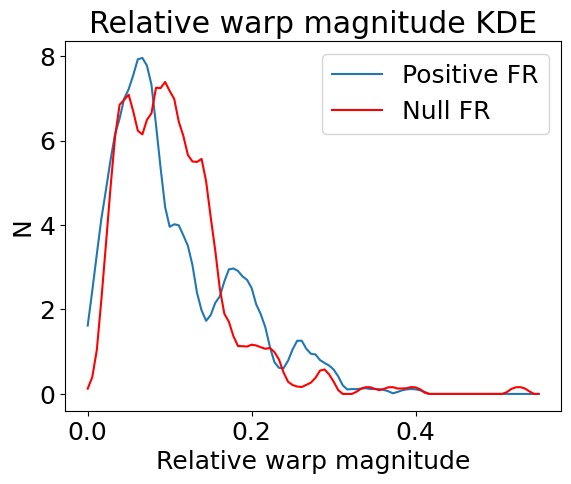

In [36]:
#Plot KDE for inner and out mass datasets
x = np.linspace(0,.55,100)
plt.plot(x,KDE(x,silverman(rel_warp_magnitudes.flatten()),rel_warp_magnitudes.flatten()),label = 'Positive FR')
plt.plot(x,KDE(x,silverman(ctrl_rel_warp_magnitudes.flatten()),ctrl_rel_warp_magnitudes.flatten()),label = 'Null FR',c='r')
plt.xlabel('Relative warp magnitude')
plt.ylabel('N')
plt.title('Relative warp magnitude KDE')
plt.legend()

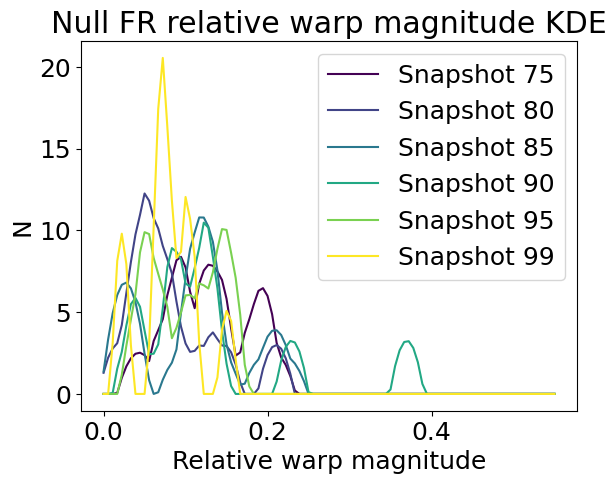

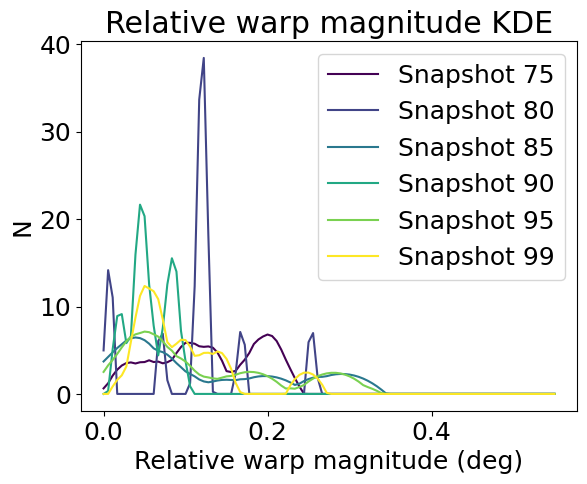

In [27]:
h = [silverman(ctrl_rel_warp_magnitudes[:,i]) for i in np.arange(25)]
x = np.linspace(0,.55,100)

KDE_data = [KDE(x, h[i], ctrl_rel_warp_magnitudes[:,i]) for i in np.arange(25)]
colors = plt.cm.viridis(np.linspace(0, 1, 6))

for idx,i in enumerate([0,5,10,15,20,24]):
    plt.plot(x,KDE_data[i],color=colors[idx],label=f'Snapshot {75+i}')
    
plt.xlabel('Relative warp magnitude')
plt.ylabel('N')
plt.title('Null FR relative warp magnitude KDE')
plt.legend()

plt.figure()
h = [silverman(rel_warp_magnitudes[:,i]) for i in np.arange(25)]

KDE_data = [KDE(x, h[i], rel_warp_magnitudes[:,i]) for i in np.arange(25)]
colors = plt.cm.viridis(np.linspace(0, 1, 6))

for idx,i in enumerate([0,5,10,15,20,24]):
    plt.plot(x,KDE_data[i],color=colors[idx],label=f'Snapshot {75+i}')
    
plt.xlabel('Relative warp magnitude (deg)')
plt.ylabel('N')
plt.title('Relative warp magnitude KDE')
plt.legend()

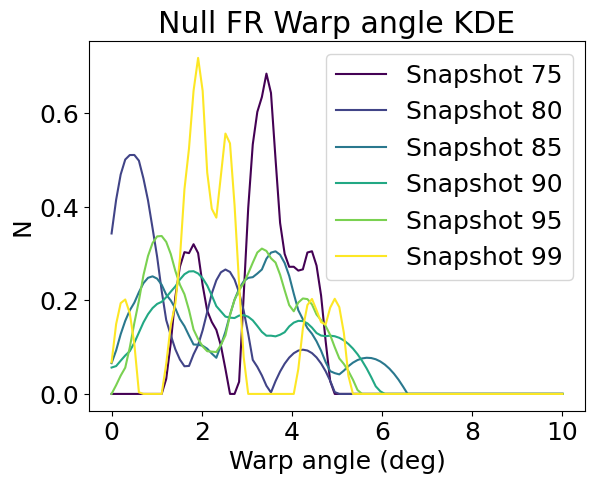

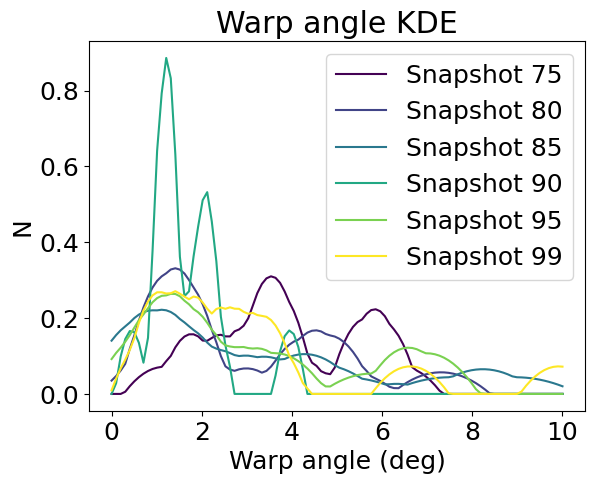

In [23]:
h = [silverman(ctrl_warp_z_angles[:,i]) for i in np.arange(25)]
x = np.linspace(0,10,100)

KDE_data = [KDE(x, h[i], ctrl_warp_z_angles[:,i]) for i in np.arange(25)]
colors = plt.cm.viridis(np.linspace(0, 1, 6))

for idx,i in enumerate([0,5,10,15,20,24]):
    plt.plot(x,KDE_data[i],color=colors[idx],label=f'Snapshot {75+i}')
    
plt.xlabel('Warp angle (deg)')
plt.ylabel('N')
plt.title('Null FR Warp angle KDE')
plt.legend()

plt.figure()
h = [silverman(rel_warp_magnitudes[:,i]) for i in np.arange(25)]
x = np.linspace(0,10,100)

KDE_data = [KDE(x, h[i], warp_z_angles[:,i]) for i in np.arange(25)]
colors = plt.cm.viridis(np.linspace(0, 1, 6))

for idx,i in enumerate([0,5,10,15,20,24]):
    plt.plot(x,KDE_data[i],color=colors[idx],label=f'Snapshot {75+i}')
    
plt.xlabel('Warp angle (deg)')
plt.ylabel('N')
plt.title('Warp angle KDE')
plt.legend()

We can see that generally, the group of galaxies with positive FR detections enable a wider range of warp than in the group with null detections.

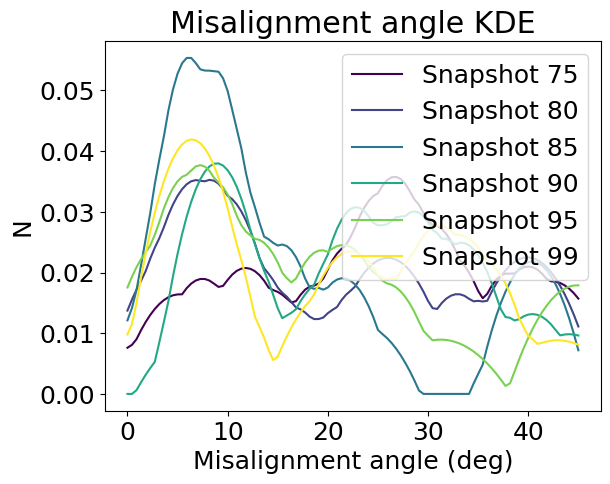

In [24]:
h = [silverman(disky_angles[:,i]) for i in np.arange(25)]
x = np.linspace(0,45,100)

KDE_data = [KDE(x, h[i], disky_angles[:,i]) for i in np.arange(25)]
colors = plt.cm.viridis(np.linspace(0, 1, 6))

for idx,i in enumerate([0,5,10,15,20,24]):
    plt.plot(x,KDE_data[i],color=colors[idx],label=f'Snapshot {75+i}')
    
plt.xlabel('Misalignment angle (deg)')
plt.ylabel('N')
plt.title('Misalignment angle KDE')
plt.legend()

We can see generally, the areas where the misalignemnt angles peak the most are within 20 degrees of the spin axis. 

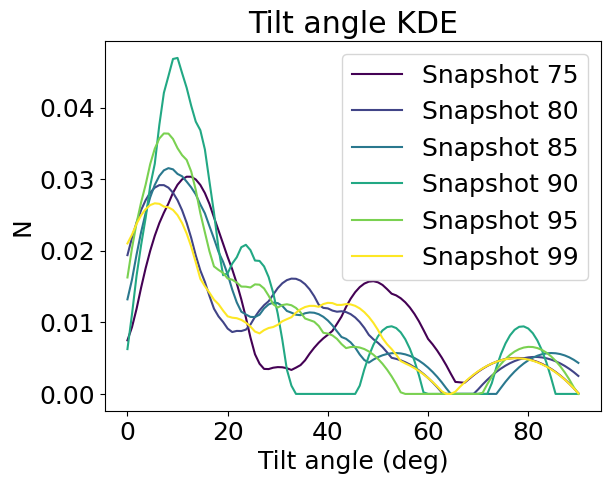

In [25]:
h = [silverman(z_angles[:,i]) for i in np.arange(25)]
x = np.linspace(0,90,100)

KDE_data = [KDE(x, h[i], z_angles[:,i]) for i in np.arange(25)]
colors = plt.cm.viridis(np.linspace(0, 1, 6))

for idx,i in enumerate([0,5,10,15,20,24]):
    plt.plot(x,KDE_data[i],color=colors[idx],label=f'Snapshot {75+i}')
    
plt.xlabel('Tilt angle (deg)')
plt.ylabel('N')
plt.title('Tilt angle KDE')
plt.legend()

The tilt angle has a very large peak to be within 20 degrees of the disk spin axis, but we also see there are also some local peaks at 90 degrees tilted and midway between the two.

Now, let's see if we can recreate Jesse Han's landmark figure for a select number of halos.

In [26]:
lookback_time= [3.966, 3.269, 2.48, 1.66, .81, 0]

In [29]:
archetypal_indices = [2,3,5,6,9]

In [1]:
for diskyidx in archetypal_indices:
    f, ((ax1, ax2)) = plt.subplots(2, 1, sharex=True)
    ax1.set_title(real_disky_GrNr[diskyidx])
    ax1.set_ylim(0,90)
    ax1.errorbar(np.arange(25), z_angles[diskyidx], yerr = z_angles_stds[diskyidx])
    ax1.set_ylabel('Tilt Angle (°)', fontsize = 'xx-small')    

    ax2.errorbar(np.arange(25), warp_magnitudes[diskyidx], yerr = warp_mags_stds[diskyidx]) 
    ax2.set_ylabel(r'Warp Amplitude [kpc/$h$]', fontsize = 'xx-small')

    ax2.set_xticks(np.linspace(0,25,6),lookback_time)
    ax2.set_xlabel('Lookback time (Gyr)')

NameError: name 'archetypal_indices' is not defined

This result is interesting for this specific investigation! While we have do have halos out of our 12 with significant tilt, we can see these halos with very little tilt still exhibit significant warp. Let's then check how they fare with misalignment evolution. 

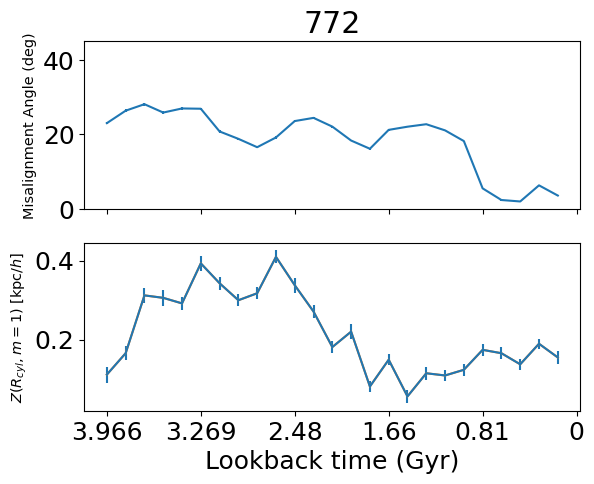

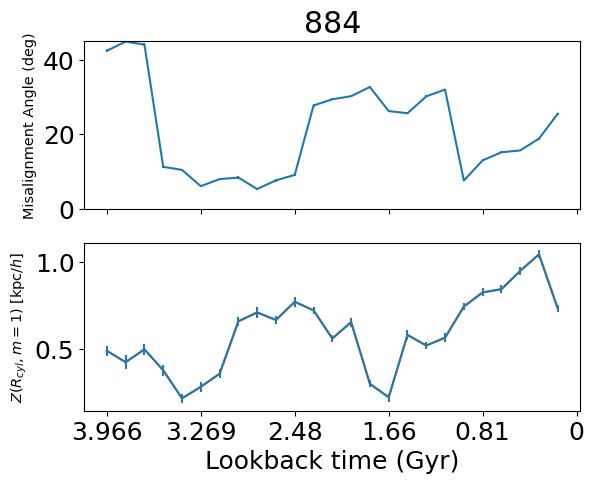

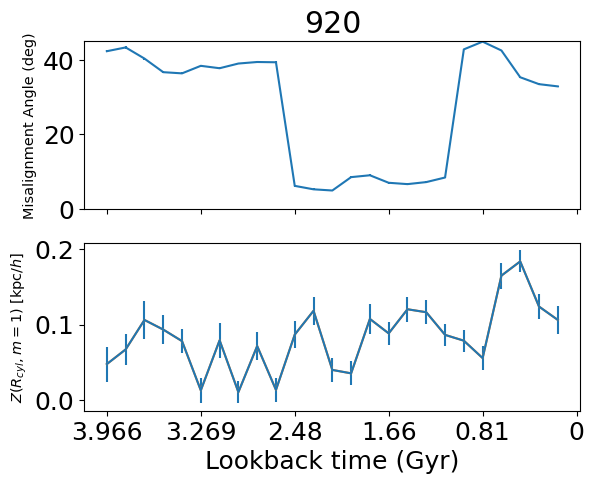

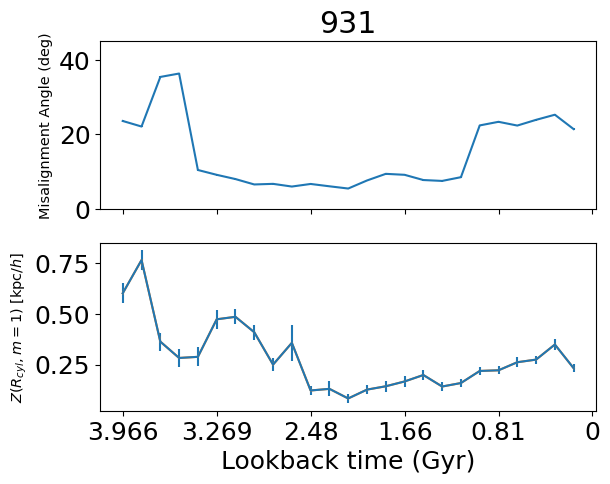

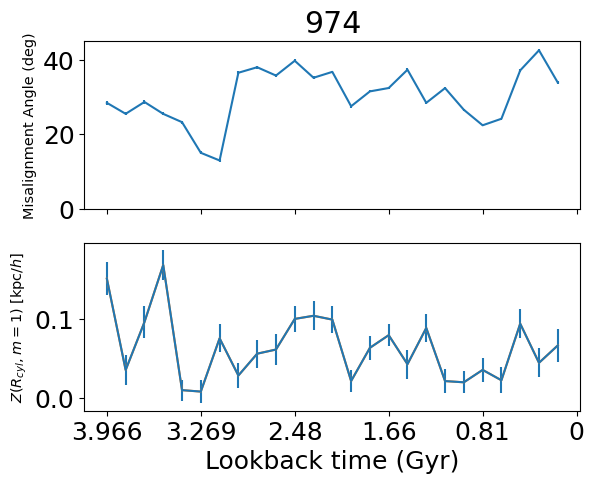

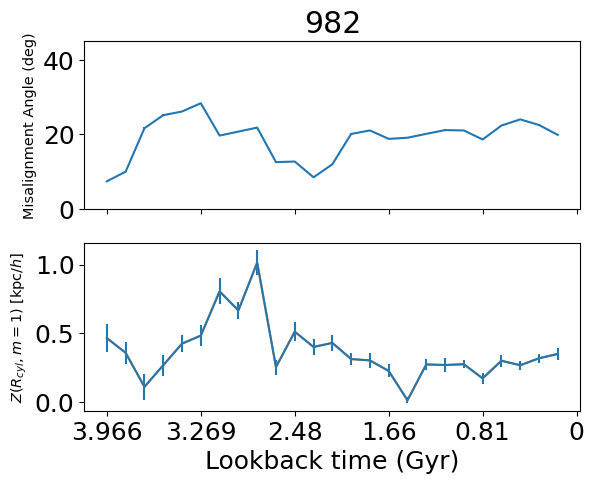

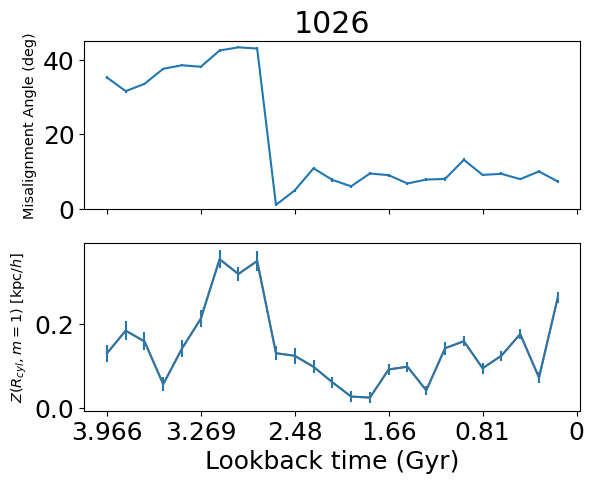

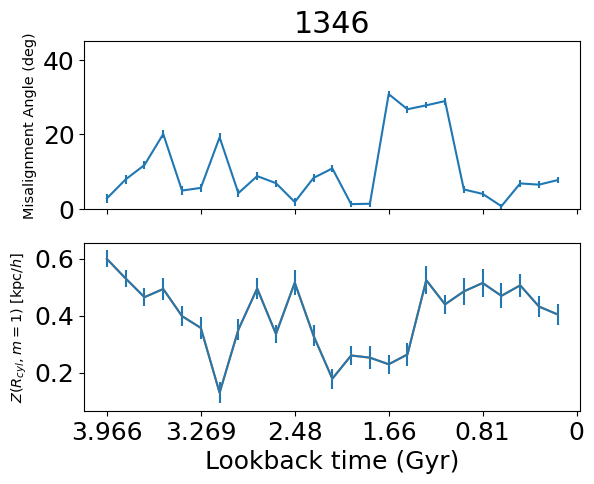

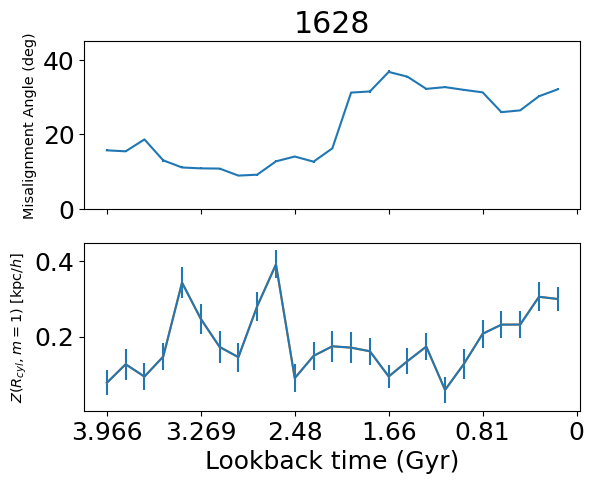

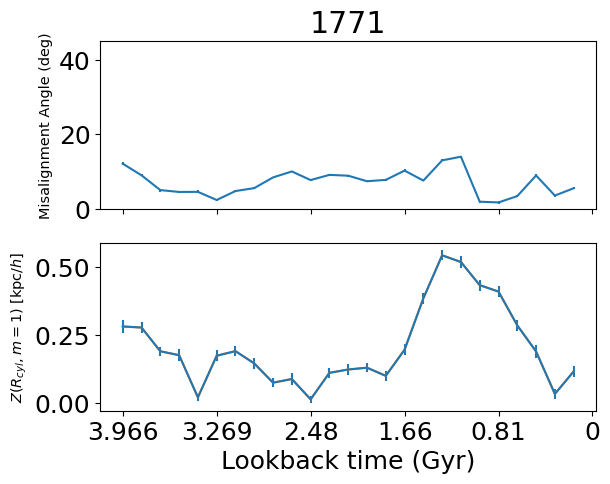

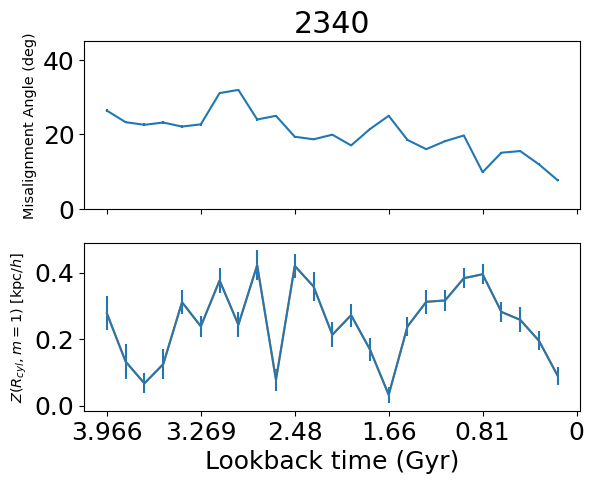

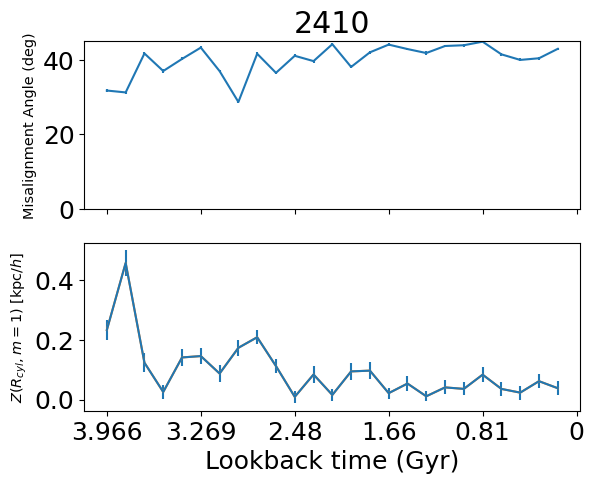

In [41]:
for diskyidx in range(12):
    f, ((ax1, ax2)) = plt.subplots(2, 1, sharex=True)
    ax1.set_title(real_disky_GrNr[diskyidx])
    ax1.set_ylim(0,45)
    ax1.errorbar(np.arange(25), disky_angles[diskyidx], yerr = disky_angles_stds[diskyidx])
    ax1.set_ylabel('Misalignment Angle (deg)', fontsize = 'xx-small')
    ax2.errorbar(np.arange(25), warp_magnitudes[diskyidx], yerr = warp_mags_stds[diskyidx]) 
    ax2.plot(np.arange(25), warp_magnitudes[diskyidx]) 
    ax2.set_xticks(np.linspace(0,25,6),lookback_time)
    ax2.set_xlabel('Lookback time (Gyr)')
    ax2.set_ylabel(r'$Z(R_{cyl},m=1)$ [kpc/$h$]', fontsize = 'xx-small')

For these archetypal halos, we can match peaks and valleys to argue a 1 Gyr-lagged correlation for some halos in some regions of the plots, or we could argue for direct correlation similarly. This leads to two explanations, respectively: for the former, figure rotation influences warp in some part; for the latter, an external factor is influencing warp and figure rotation simultaenously. Either way, we're not getting the whole story through just this.

I should investigate then whether a lagged signal correlation is what we're really seeing, by plotting scatter plots of the warp angle as a function of the tilt/misalignment angle for each snapshot. I also implement a total plot that is colorbarred with snapshot to get a feeling of the total picture. We also a least-likelihood orthogonal fit to get a sense of the linear correlation outside of the Pearson test as well as generate confidence intervals.

In [29]:
nvalues = range(25)
hsv2rgb = lambda hue: mcolors.hsv_to_rgb([hue,0.9,0.7])
hues = np.linspace(0, 0.7, len(nvalues))
colors = [hsv2rgb(hue) for hue in hues]

cmap, norm = mcolors.from_levels_and_colors(range(len(nvalues) + 1), colors)
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)

In [30]:
best_snaps = [0,12,24]

In [31]:
#Define orthoogonal fit function
def neglogLikelihood_orth( p, xb, yb, dxb, dyb ):
    a = p[0]
    b = p[1]
    sig = p[2]
    theta = np.arctan(b)
    delta = (yb-a)*np.cos(theta) - xb*np.sin(theta)
    sigma_square = np.square(dyb*np.cos(theta)) + np.square(dxb*np.sin(theta))
    logL = -np.sum(np.log(sigma_square+sig**2)) - np.sum(delta**2/(sigma_square**2+sig**2))
    return -logL

In [32]:
from scipy import optimize

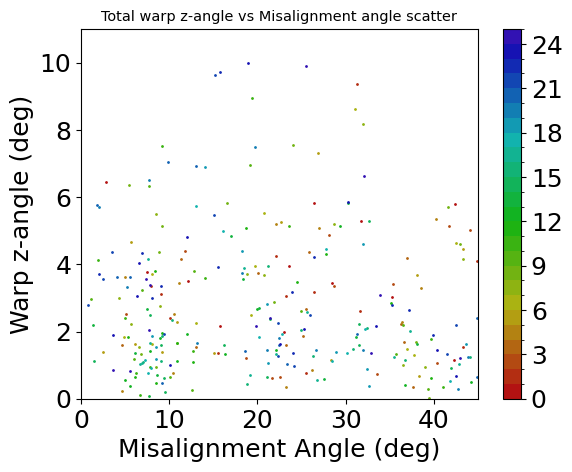

<Figure size 640x480 with 0 Axes>

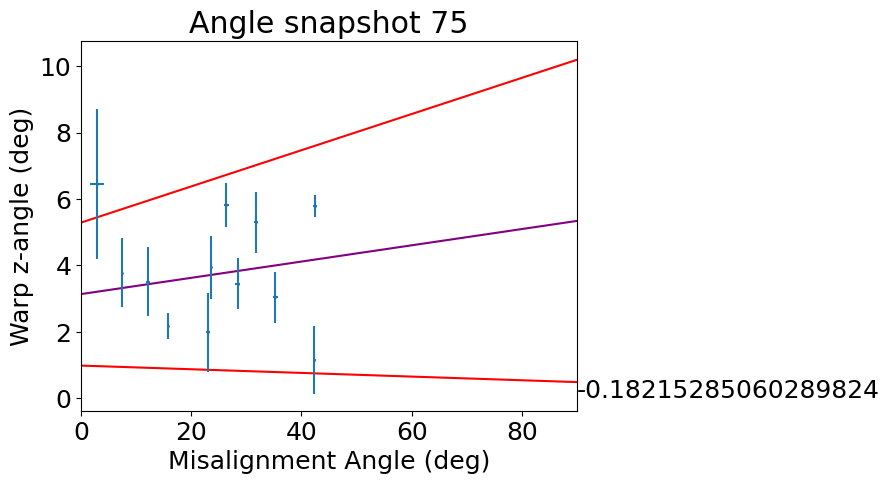

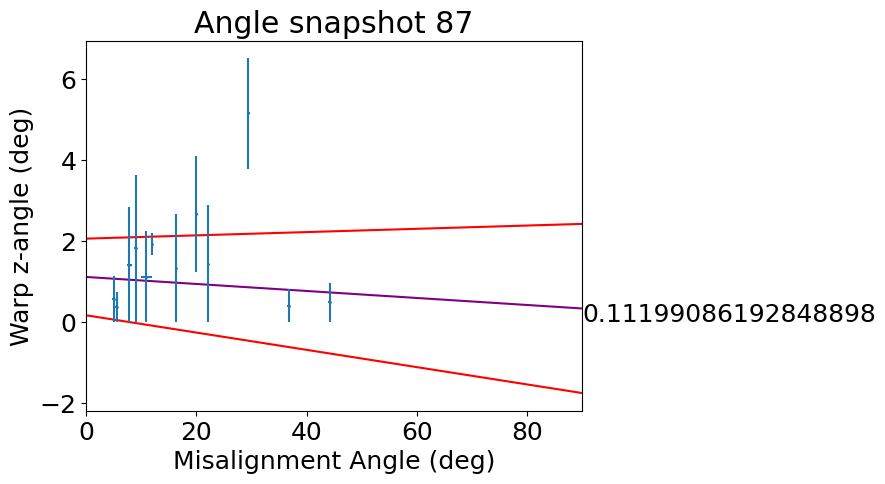

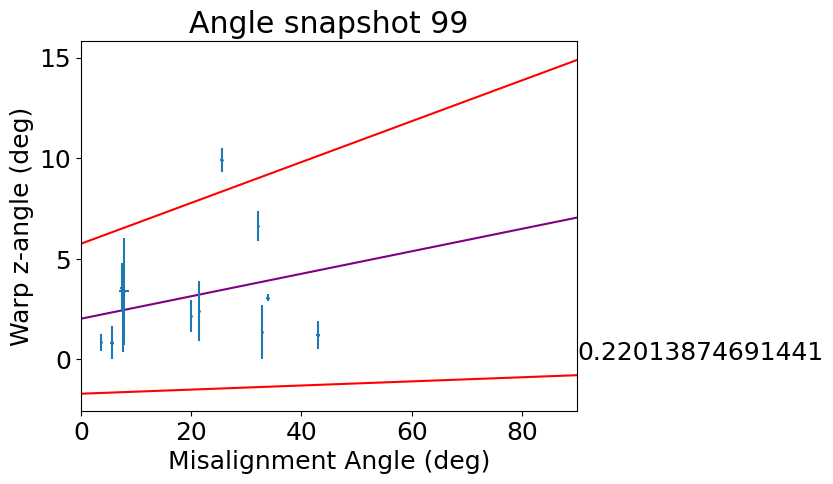

In [34]:
plt.xlim(0,45)
plt.ylim(0,11)
for snap in range(25):
    plt.scatter(disky_angles[:,snap],warp_z_angles[:,snap],s=1,color=colors[snap]) 
plt.xlabel('Misalignment Angle (deg)')
plt.ylabel('Warp z-angle (deg)')
plt.title("Total warp z-angle vs Misalignment angle scatter",fontsize = 'xx-small')
plt.colorbar(sm)
plt.figure()

for snap in best_snaps:
    
    orth_o = optimize.minimize(neglogLikelihood_orth, [1.,1.,1.], \
                               args=(disky_angles[:,snap], warp_z_angles[:,snap], \
                                     disky_angles_stds[:,snap], warp_z_angles_stds[:,snap]))

    a_o = orth_o.x[0]
    b_o = orth_o.x[1]
    sig_o = orth_o.x[2]
    da_o = np.sqrt(orth_o.hess_inv[0,0])
    db_o = np.sqrt(orth_o.hess_inv[1,1])
    dsig_o = np.sqrt(orth_o.hess_inv[2,2])

    xa_o = np.linspace(np.min(x)-1, np.max(x)+1)
    plt.figure()
    plt.plot(xa_o, a_o + b_o*xa_o, color = 'purple')
    plt.plot(xa_o, a_o+da_o+sig_o + (b_o+db_o)*xa_o, c = 'red')
    plt.plot(xa_o, a_o-da_o-sig_o + (b_o-db_o)*xa_o, c= 'red')
    plt.xlim(0,90)
    plt.errorbar(np.array(disky_angles)[:,snap],np.array(warp_z_angles)[:,(snap)],
                 xerr = np.array(disky_angles_stds)[:,snap], yerr = warp_z_angles_stds[:,snap], fmt = 'o', markersize=1) 
    plt.xlabel('Misalignment Angle (deg)')
    plt.ylabel('Warp z-angle (deg)')
    plt.title(f'Angle snapshot {75+snap}')
    plt.annotate(stats.pearsonr((np.array(disky_angles)[:,snap]),np.array(warp_z_angles)[:,(snap)])[0],(90,0))

The most interesting result with the total plots is that while our direct linear correlation might not be the best, there is clearly a limiting magnitude to the warp achievable for a given tilt/misalignment angle, i.e. the larger our tilt/misalignment angle is, the range of warp observed is larger. Our direct correlation with no time lag is perhaps, not optimal, so let's use an analytical method of finding what a lag that maximizes either the total Pearson correlation or our average Pearson correlation could be.

Text(0.5, 1.0, 'Optimal lag finder for for warp vs misalignment')

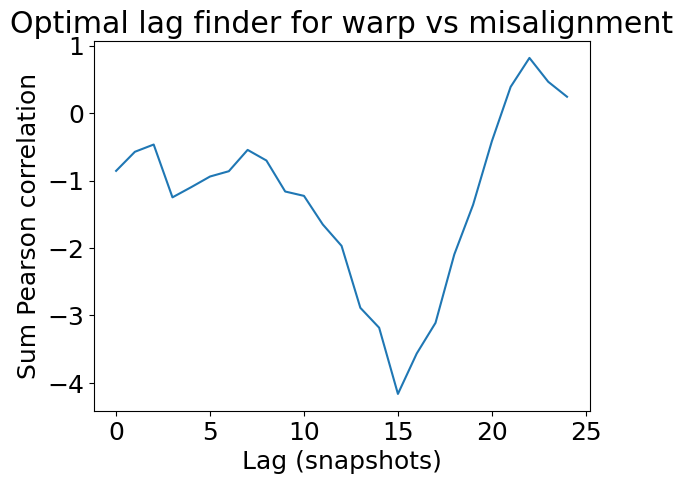

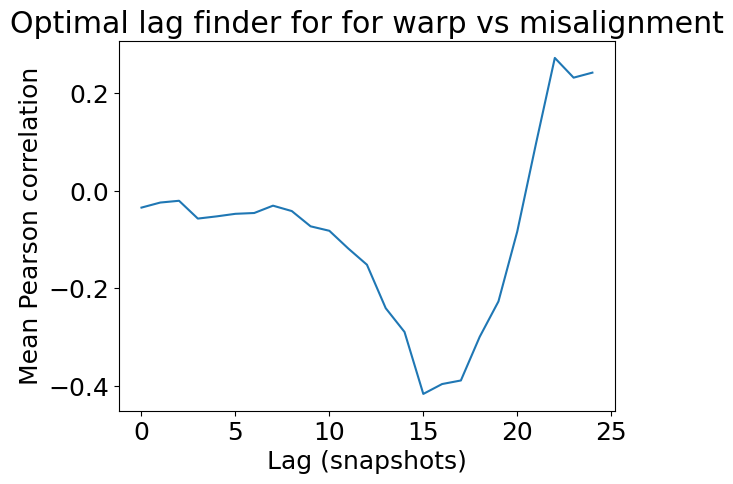

In [35]:
lag = np.arange(25)
sum_correlation = []
for i in lag:
    correlation_array = []
    for snap in range(25-i):
        correlation_array.append(stats.pearsonr(np.array(disky_angles)[:,snap],np.array(warp_z_angles)[:,(snap+i)])[0])
    sum_correlation.append(np.sum(correlation_array))
    
plt.plot(lag,sum_correlation,label="warp z-angle")
plt.xlabel("Lag (snapshots)")
plt.ylabel("Sum Pearson correlation")
plt.title("Optimal lag finder for warp vs misalignment")

avg_correlation = []
for i in lag:
    correlation_array = []
    for snap in range(25-i):
        correlation_array.append(stats.pearsonr(np.array(disky_angles)[:,snap],np.array(warp_z_angles)[:,(snap+i)])[0])
    avg_correlation.append(np.mean(correlation_array))
plt.figure()    
plt.plot(lag,avg_correlation,label="warp z-angle")
plt.xlabel("Lag (snapshots)")
plt.ylabel("Mean Pearson correlation")
plt.title("Optimal lag finder for for warp vs misalignment")

We should generally trust the averaged correlation more, so let's try the peak averaged lag of 19 snasphots.

In [36]:
single_lag = 22

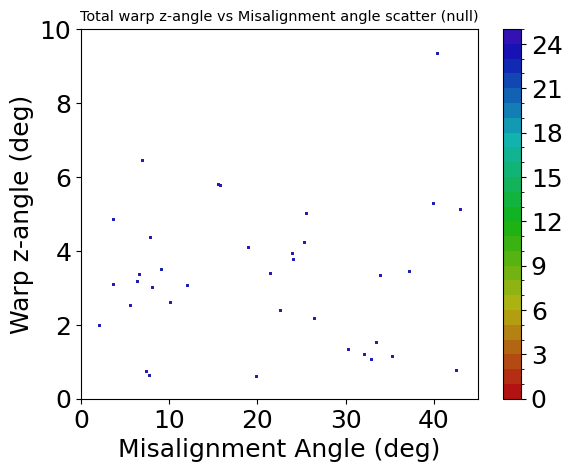

<Figure size 640x480 with 0 Axes>

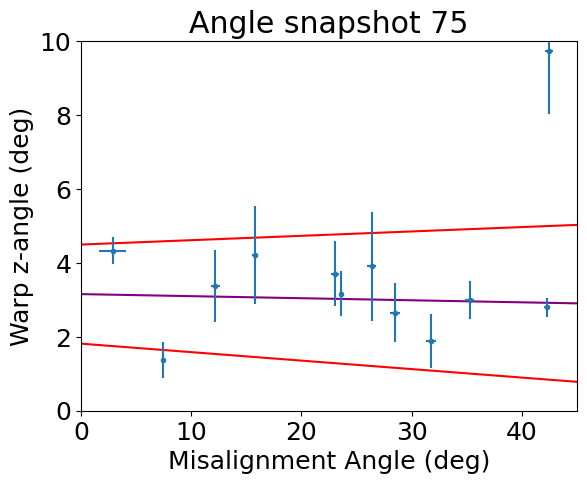

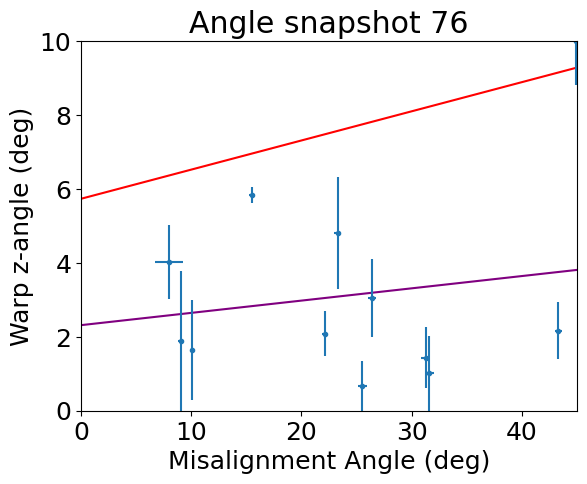

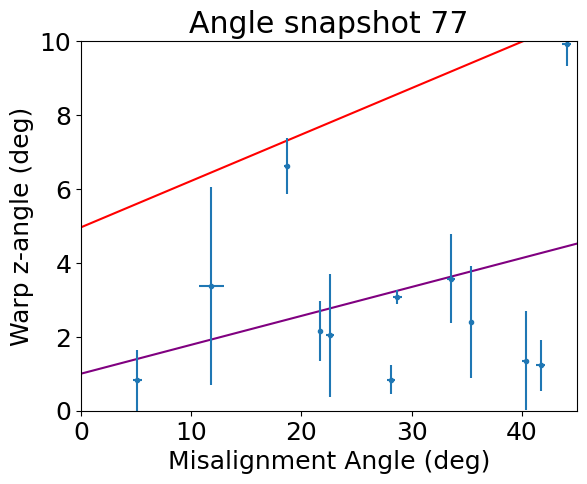

In [38]:
plt.xlim(0,45)
plt.ylim(0,10)
for snap in range(25):
    plt.scatter(disky_angles[:,single_lag:],warp_z_angles[:,:-single_lag],s=1,color=colors[snap]) 
plt.xlabel('Misalignment Angle (deg)')
plt.ylabel('Warp z-angle (deg)')
plt.title("Total warp z-angle vs Misalignment angle scatter (null)",fontsize = 'xx-small')
plt.colorbar(sm)
plt.figure()

for snap in range(25-single_lag):
    plt.figure()
    plt.xlim(0,45)
    plt.ylim(0,10)

    orth_o = optimize.minimize(neglogLikelihood_orth, [1.,1.,1.], \
                               args=(disky_angles[:,snap], warp_z_angles[:,(snap+single_lag)], \
                                     disky_angles_stds[:,snap], warp_z_angles_stds[:,(snap+single_lag)]))

    a_o = orth_o.x[0]
    b_o = orth_o.x[1]
    sig_o = orth_o.x[2]
    da_o = np.sqrt(orth_o.hess_inv[0,0])
    db_o = np.sqrt(orth_o.hess_inv[1,1])
    dsig_o = np.sqrt(orth_o.hess_inv[2,2])

    xa_o = np.linspace(np.min(x)-1, np.max(x)+1)
    plt.plot(xa_o, a_o + b_o*xa_o, color = 'purple')
    plt.plot(xa_o, a_o+da_o+sig_o + (b_o+db_o)*xa_o, c = 'red')
    plt.plot(xa_o, a_o-da_o-sig_o + (b_o-db_o)*xa_o, c= 'red')
    plt.errorbar(np.array(disky_angles)[:,snap],np.array(warp_z_angles)[:,(snap+single_lag)],
                 xerr = np.array(disky_angles_stds)[:,snap],yerr = np.array(warp_z_angles_stds)[:,snap+single_lag], fmt = 'o', markersize=3) 
    plt.xlabel('Misalignment Angle (deg)')
    plt.ylabel('Warp z-angle (deg)')
    plt.title(f'Angle snapshot {75+snap}')
    plt.annotate(stats.pearsonr((np.array(disky_angles)[:,snap]),np.array(warp_z_angles)[:,(snap+single_lag)])[0],(90,0))

We can see that we do get a stronger correlation in later snapshots, it's maybe still not the most convincing result. There's actually two issues this raises. The first is that if the lag really is 19 snapshots, that's around 3 Gyr, meaning the correlation we're looking for is almost beyond the scale of the warp and misalignment evolution plots.

The scond is that we could maybe say for non-tilted halos that figure rotation is a likely cause of warp, but what of halos that have figure rotation and significant tilt? Recall that I said majority of the FR axes are aligned with the minor axis. The other thing to consider is when that isn't true, when the FR axis aligns itself with the major axis of the DM halo or even in between:

100%|██████████| 6/6 [00:00<00:00, 118.45it/s]


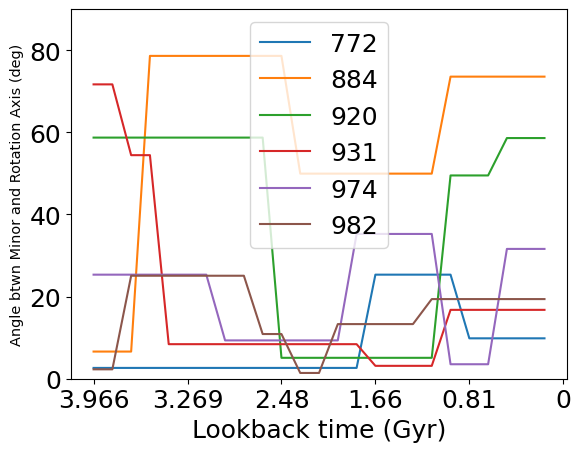

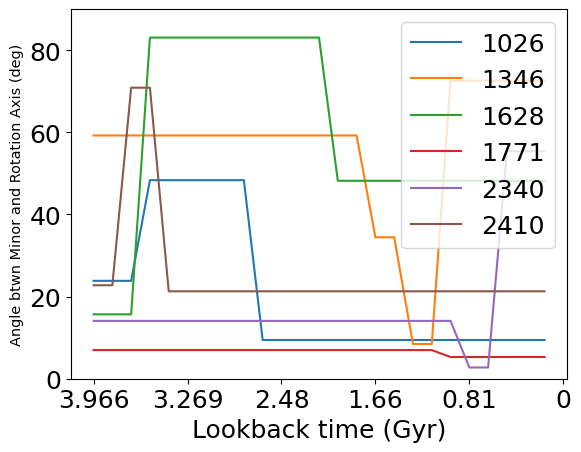

In [49]:
for id in tqdm(range(6)):
    plt.plot(np.arange(25),separation_angles[id],label=real_disky_GrNr[id])
    plt.ylim(0,90)
    plt.xticks(np.linspace(0,25,6),lookback_time)
    plt.xlabel('Lookback time (Gyr)')
    plt.ylabel('Angle btwn Minor and Rotation Axis (deg)',fontsize='xx-small')
    plt.legend()
plt.figure()
for id in tqdm(range(6,12)):
    plt.plot(np.arange(25),separation_angles[id],label=real_disky_GrNr[id])
    plt.ylim(0,90)
    plt.xticks(np.linspace(0,25,6),lookback_time)
    plt.xlabel('Lookback time (Gyr)')
    plt.ylabel('Angle btwn Minor and Rotation Axis (deg)',fontsize='xx-small')
    plt.legend()

These plots are separated just by sequential group number, but we do get to see the plot directly above has halos with fairly constant separation between the minor and figure rotation axis, with the exception of 2410 and 2340. 2410's almost 90-degree separation is likely an alignment with the major axis, but 2340 is a bit more separated. These three components --- the tilt angle, the misalignment angle, and the angle of separation between the minor and figure rotation axes --- could have a combined effect on the warp of the disk. The issue now is to come up with a metric that considers these three factors based on their combined geometry, or graph these multiple components together to see correlation with warp measurements.

This project is still in progress and I'm reviewing right now how the separation between the tilt and misalignment angle would overall physically affect the halo. I am also looking at how to apply other numerical methods to this dataset. While 406 has improved my confidence in Python and given me a number of useful methods to work with and analyze TNG data, I know there's more I can do outside the scope of this class. I'm currently also interested in using scipy.correlate to quantify a lagged correlation between the warp and misalignment/tilt angle evolutions as well envelope statistics on my total plots. That'll have to be after I wrap up the semester, however. Thank you for reading and for the wonderful class :)